In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('data/application_data.csv')
description = pd.read_csv('data/columns_description.csv')

# if want to return the description of certain column
def desc(x) :
    desc = description[['Row','Description']].loc[description['Row']==x, 'Description']
    return desc.iloc[0] if not desc.empty else None

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


Population Default Rate = 0.0807(8.1%)
Cutoff range for significance (sample size = 500):
Lower cutoff = 0.0569 (5.7%)
Upper cutoff = 0.1046 (10.5%)


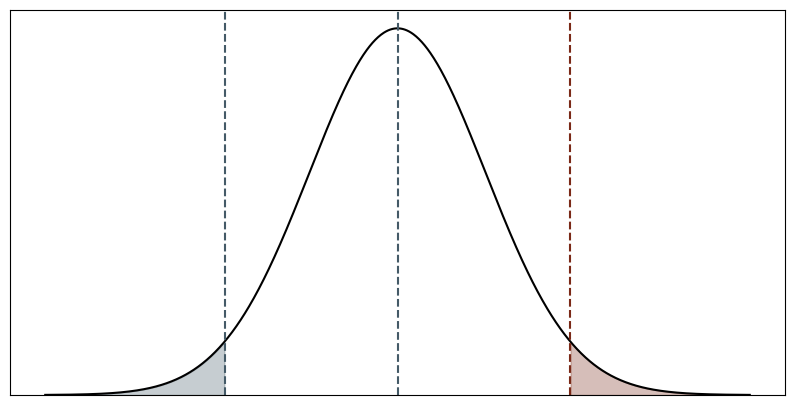

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

df1 = df.copy()

# Population default rate (p0)
p0 = df1['TARGET'].mean()

# Fixed sample size for cutoff calculation
fixed_n = 500

# Calculate standard error and z critical value
z_critical = norm.ppf(1 - 0.05 / 2)  # 95% confidence
std_error = np.sqrt(p0 * (1 - p0) / fixed_n)

# Calculate cutoff values
lower_cutoff = p0 - z_critical * std_error
upper_cutoff = p0 + z_critical * std_error

print(f"Population Default Rate = {p0:.4f}({p0*100:.1f}%)")
print(f"Cutoff range for significance (sample size = {fixed_n}):")
print(f"Lower cutoff = {lower_cutoff:.4f} ({lower_cutoff*100:.1f}%)")
print(f"Upper cutoff = {upper_cutoff:.4f} ({upper_cutoff*100:.1f}%)")

# Simulated sampling distribution (under null hypothesis)
x = np.linspace(p0 - 4*std_error, p0 + 4*std_error, 1000)
y = norm.pdf(x, loc=p0, scale=std_error)


plt.figure(figsize=(10, 5))
plt.plot(x, y, label='Sampling Distribution', color='black')

# Population mean line
plt.axvline(p0, color='#445A67', linestyle='--', label='Population Mean')

# Lower cutoff line (blue)
plt.axvline(lower_cutoff, color='#445A67', linestyle='--', label='2.5% cutoff')

# Upper cutoff line (red)
plt.axvline(upper_cutoff, color='#7A2917', linestyle='--', label='97.5% cutoff')

# Fill lower tail with blue
plt.fill_between(x, y, where=(x < lower_cutoff), color='#445A67', alpha=0.3)

# Fill upper tail with red
plt.fill_between(x, y, where=(x > upper_cutoff), color='#7A2917', alpha=0.3)

# Optional: hiding ticks and grid
plt.ylim(bottom=0)
plt.grid(False)
plt.xticks([])
plt.yticks([])

plt.show()

In [27]:

# CREDIT QUANTILES
credit_qcut, credit_bins = pd.qcut(df1['AMT_CREDIT'], q=8, retbins=True, duplicates='drop')
credit_labels = [
    f'{i+1}/8 quantile ({int(credit_bins[i]):,} to {int(credit_bins[i+1]):,})'
    for i in range(len(credit_bins)-1)
]
df1['CREDIT_AMOUNT_Q'] = pd.qcut(df1['AMT_CREDIT'], q=8, labels=credit_labels, duplicates='drop')

# INCOME QUANTILES
income_qcut, income_bins = pd.qcut(df1['AMT_INCOME_TOTAL'], q=10, retbins=True, duplicates='drop')
income_labels = [
    f'{i+1}/10 quantile ({int(income_bins[i]):,} to {int(income_bins[i+1]):,})'
    for i in range(len(income_bins)-1)
]
df1['AMT_INCOME_TOTAL_Q'] = pd.qcut(df1['AMT_INCOME_TOTAL'], q=10, labels=income_labels, duplicates='drop')


def child_group(n):
    if n == 0:
        return '0chd'
    elif n == 1:
        return '1chd'
    elif n == 2:
        return '2chd'
    elif n == 3:
        return '3chd'
    else:
        return 'above3'

df1['CHILD_GROUP'] = df1['CNT_CHILDREN'].apply(child_group)

# Columns to analyze
CatColumn = [
    'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE',
    'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
    'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START',
    'CREDIT_AMOUNT_Q', 'AMT_INCOME_TOTAL_Q', 'CHILD_GROUP'
]

results = []

for col in CatColumn:
    grouped = df1.groupby(col)['TARGET'].agg(
        Repaid=lambda t: (t == 0).sum(),
        Default=lambda t: (t == 1).sum(),
        Total='count'
    ).reset_index()

    grouped['DefaultRate'] = grouped['Default'] / grouped['Total']
    grouped['Column'] = col
    grouped.rename(columns={col: 'Group'}, inplace=True)

    for _, row in grouped.iterrows():
        if row['Total'] < fixed_n:
            continue

        significant = 'Yes' if (row['DefaultRate'] < lower_cutoff or row['DefaultRate'] > upper_cutoff) else 'No'

        results.append({
            'Column': col,
            'Group': row['Group'],
            'Repaid': int(row['Repaid']),
            'Default': int(row['Default']),
            'Total': int(row['Total']),
            'DefaultRate_%': round(row['DefaultRate'] * 100, 2),
            'Significant': significant
        })

# Create DataFrame of results
significance_df = pd.DataFrame(results)

# Filter only significant groups and sort
significant_only_df = significance_df[significance_df['Significant'] == 'Yes']
significant_only_df = significant_only_df.sort_values(by='DefaultRate_%').reset_index(drop=True)

# Show final result
significant_only_df


/var/folders/82/038lb7sx7w981ctcvb0s2px00000gn/T/ipykernel_31463/3426831371.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df1.groupby(col)['TARGET'].agg(
/var/folders/82/038lb7sx7w981ctcvb0s2px00000gn/T/ipykernel_31463/3426831371.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df1.groupby(col)['TARGET'].agg(


,Column,Group,Repaid,Default,Total,DefaultRate_%,Significant
0,OCCUPATION_TYPE,Accountants,9339,474,9813,4.83,Yes
1,NAME_EDUCATION_TYPE,Higher education,70854,4009,74863,5.36,Yes
2,NAME_INCOME_TYPE,Pensioner,52380,2982,55362,5.39,Yes
3,CREDIT_AMOUNT_Q,"8/8 quantile (1,078,200 to 4,050,000)",36072,2055,38127,5.39,Yes
4,OCCUPATION_TYPE,Laborers,49348,5838,55186,10.58,Yes
5,CREDIT_AMOUNT_Q,"5/8 quantile (513,531 to 646,920)",34281,4088,38369,10.65,Yes
6,OCCUPATION_TYPE,Security staff,5999,722,6721,10.74,Yes
7,NAME_EDUCATION_TYPE,Lower secondary,3399,417,3816,10.93,Yes
8,OCCUPATION_TYPE,Waiters/barmen staff,1196,152,1348,11.28,Yes
9,OCCUPATION_TYPE,Drivers,16496,2107,18603,11.33,Yes
